# Regression

Concepts:
- Regression Models
- Hyperparameter Tuning
- Information Criterion


In [55]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from pandas.api.types import is_list_like, is_numeric_dtype
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error    
import time
from finds.readers.alfred import Alfred, fred_qd, fred_md
from finds.utils import plot_date
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [56]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=-1)

In [57]:
# Get FRED-MD data
freq = 'M' 
beg = 19640701  # 19620701
split_date = 20221231
df, t = fred_md()   # 
transforms = t['transform']
end = df.index[-2]

FRED-MD vintage: monthly/current.csv


In [58]:
# Splice in common updates: source of PE ratio, Commercial Paper
for col in ['S&P PE ratio']:
    df[col] = alf.splice(col)
df['COMPAPFF'] = df['COMPAPFF'].ffill()  # forward fill 20200430
df['CP3M'] = df['CP3M'].ffill()          # forward fill 20200430

In [59]:
# Apply transformations
transformed = []
for col in df.columns:
    transformed.append(alf.transform(df[col], tcode=transforms[col], freq=freq))
data = pd.concat(transformed, axis=1).iloc[2:]
c = list(data.columns)
data = data.loc[(data.index >= beg) & (data.index <= end)]

In [60]:
# Drop columns with missing data
missing = []
for series_id in df.columns:
    g = data[series_id].notna()
    missing.extend([(date, series_id) for date in data.index[~g]])
missing_per_row = data.isna().sum(axis=1)
missing = DataFrame.from_records(missing, columns=['date', 'series_id'])
print('original:', data.shape, 'dropna:', data.dropna(axis=1).shape)
data = data.dropna(axis=1)   # drop columns where missing values
print(missing['series_id'].value_counts())
data

original: (716, 126) dropna: (716, 122)
series_id
ACOGNO          332
UMCSENT         163
TWEXAFEGSMTH    103
ANDENO           44
Name: count, dtype: int64


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLS
19640731,0.005422,0.005404,0.007343,0.019986,0.004947,0.006551,0.010344,0.011309,0.014078,0.016436,...,0.000667,-0.000369,-0.000090,-0.000016,0.003231,-0.004158,-0.003798,-0.002430,-0.002831,11.2238
19640831,0.005644,0.006061,0.005992,-0.020139,0.013974,0.006508,-0.000936,-0.000939,-0.001865,0.007223,...,-0.002031,-0.002398,0.001406,-0.000016,-0.003263,0.004141,-0.005958,-0.001818,0.011673,13.6898
19640930,0.004123,0.004205,-0.004164,0.027173,0.009372,0.003699,-0.004690,-0.003758,-0.011266,-0.023659,...,0.000728,0.003749,-0.001674,-0.000015,-0.006462,0.004090,-0.011142,-0.003802,0.010582,10.5167
19641031,0.000555,0.000650,0.006499,-0.013866,-0.039421,-0.013947,-0.010403,-0.013272,-0.020031,-0.109873,...,-0.001712,-0.002344,0.000525,-0.011757,0.016093,-0.024760,0.005974,-0.000704,-0.003579,11.0924
19641130,0.006703,0.007352,-0.009111,-0.009745,0.009335,0.030432,0.029040,0.031929,0.036883,0.128118,...,0.004137,0.000985,-0.000352,0.011772,-0.019272,0.024828,-0.009946,-0.002806,-0.002694,12.0087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231031,0.002011,0.002671,0.001534,-0.001822,-0.001868,-0.007083,-0.003736,-0.005295,-0.006291,-0.043572,...,-0.001469,-0.006139,-0.002998,-0.002355,0.001729,-0.004147,0.000003,-0.000566,-0.004573,19.0462
20231130,0.003920,0.004822,0.004145,0.006184,0.001042,0.003600,0.004855,0.008046,0.007774,0.040181,...,-0.002269,-0.003030,0.000679,0.007291,0.004863,0.007839,-0.000492,0.000069,0.008778,13.8563
20231231,0.002056,0.002097,0.004578,0.006499,0.003631,-0.003146,-0.004377,-0.004537,-0.005309,0.009311,...,0.000147,0.004876,0.000458,-0.004356,-0.007758,-0.000080,0.000385,0.000526,0.018190,12.6960
20240131,0.006063,0.002633,-0.003154,-0.013142,-0.010902,-0.007865,-0.004417,-0.003318,-0.000861,-0.024891,...,0.006598,-0.002566,0.004037,-0.000355,0.008535,-0.005941,-0.002851,-0.000590,-0.009783,13.3453


Data after the split date (December 2022) are held out for testing, and are excluded from the training data set

In [61]:
# Split time series train and test set
def ts_split(X, Y, end=split_date):
    """helper to split train/test time series"""
    return X[Y.index<=end], X[Y.index>end], Y[Y.index<=end], Y[Y.index>end]

In [62]:
def columns_map(columns, lag):
    """helper to create lagged column names"""
    return {col: col + '_' + str(lag) for col in columns}

In [63]:
def columns_unmap(columns):
    """helper to extract lagged column names"""
    cols = [col.split('_') for col in columns]
    return [col[0] for col in cols], [int(col[1]) for col in cols]

In [64]:
target_id = 'INDPRO'
lags = 3   # Include up to 3 lags of exogs
Y = data[target_id].iloc[lags:]
X = pd.concat([data.shift(lag).iloc[lags:]\
               .rename(columns=columns_map(data.columns, lag))
               for lag in range(1, lags+1)],
              axis=1)
                      

In [65]:
# collect final fitted models
test = Series(name='test', dtype=float)    # collect test and train errors
train = Series(name='train', dtype=float)
final_models = {}  

## Regression models


### Forward Selection

AIC

BIC


In [66]:
def forward_select(Y, X, selected, ic='aic'):
    """helper to forward select next regressor, using sm.OLS"""
    remaining = [x for x in X.columns if x not in selected]
    results = []
    for x in remaining:
        r = sm.OLS(Y, X[selected + [x]]).fit()
        results.append({'select': x,
                        'aic': r.aic,
                        'bic': r.bic,
                        'rsquared': r.rsquared,
                        'rsquared_adj': r.rsquared_adj})
    return DataFrame(results).sort_values(by=ic).iloc[0].to_dict()

In [67]:
# find best bic, and show selection criteria scores
ic = 'bic'   # select by information criterion
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
selected = []
models = {}
for i in range(1, 32):
    select = forward_select(Y_train,
                            X_train,
                            selected,
                            ic=ic)
    models[i] = select
    selected.append(select['select'])
selected = DataFrame.from_dict(models, orient='index')
best = selected[[ic]].iloc[selected[ic].argmin()]
subset = selected.loc[:best.name].round(3)
subset.index = [alf.header(s.split('_')[0]) for s in subset['select']]
print('Forward Selection Subset')
subset

Forward Selection Subset


,select,aic,bic,rsquared,rsquared_adj
Initial Claims,CLAIMS_1,-4768.644,-4764.094,0.357,0.356
Real M2 Money Stock,M2REAL_2,-4810.935,-4801.836,0.396,0.394
"All Employees, Wholesale Trade",USWTRADE_2,-4840.491,-4826.842,0.423,0.420
"All Employees, Service-Providing",SRVPRD_2,-4861.002,-4842.803,0.441,0.438
5-Year Treasury Constant Maturity Minus Federal Funds Rate,T5YFFM_3,-4877.677,-4854.929,0.456,0.452
Total Business: Inventories to Sales Ratio,ISRATIO_2,-4891.445,-4864.147,0.468,0.463
"All Employees, Service-Providing",SRVPRD_1,-4908.643,-4876.795,0.482,0.477
"All Employees, Wholesale Trade",USWTRADE_1,-4924.049,-4887.652,0.495,0.489
"All Employees, Financial Activities",USFIRE_2,-4935.217,-4894.270,0.504,0.498
"All Employees, Retail Trade",USTRADE_1,-4947.335,-4901.839,0.514,0.507


In [68]:
DataFrame.from_dict({n: {'series_id': s.split('_')[0],
                         'lag' : s.split('_')[1],
                         'description': alf.header(s.split('_')[0])}
                     for n, s in selected.loc[:best.name, 'select'].items()},
                    orient='index').set_index('series_id')

,lag,description
series_id,,
CLAIMS,1,Initial Claims
M2REAL,2,Real M2 Money Stock
USWTRADE,2,"All Employees, Wholesale Trade"
SRVPRD,2,"All Employees, Service-Providing"
T5YFFM,3,5-Year Treasury Constant Maturity Minus Federa...
ISRATIO,2,Total Business: Inventories to Sales Ratio
SRVPRD,1,"All Employees, Service-Providing"
USWTRADE,1,"All Employees, Wholesale Trade"
USFIRE,2,"All Employees, Financial Activities"


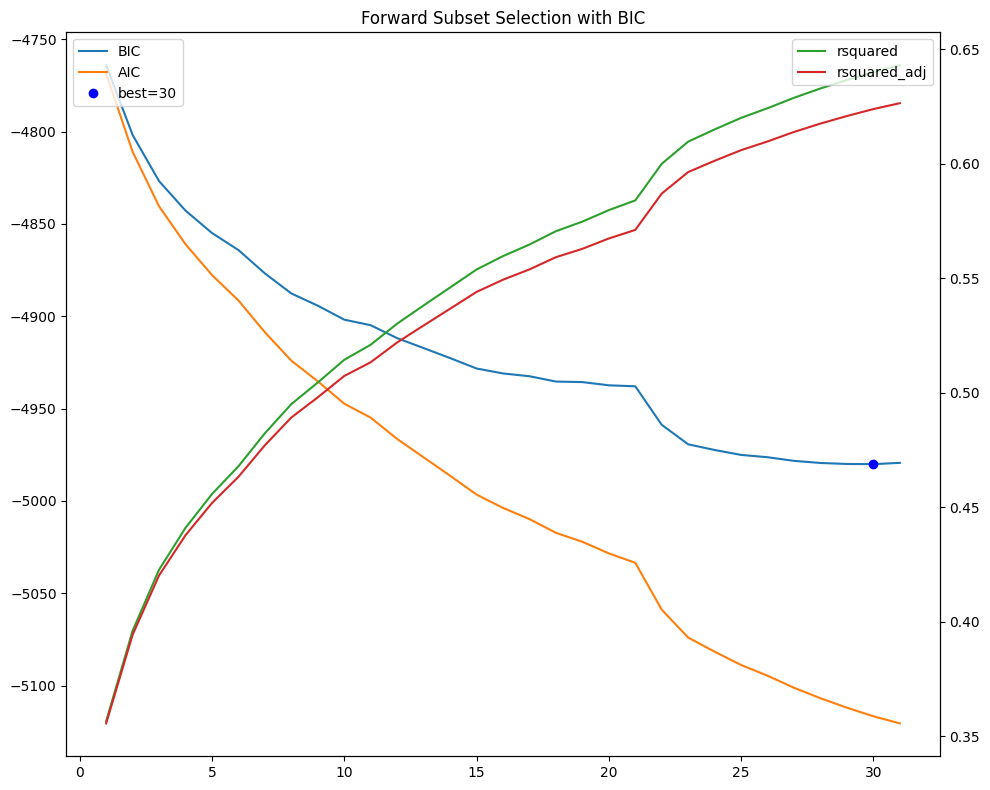

In [69]:
# Plot BIC vs number selected
fig, ax = plt.subplots(num=1, figsize=(10, 8))
selected['bic'].plot(ax=ax, c='C0')
selected['aic'].plot(ax=ax, c='C1')
ax.plot(best.name, float(best.iloc[0]), "ob")
ax.legend(['BIC', 'AIC', f"best={best.name}"], loc='upper left')
ax.set_title(f"Forward Subset Selection with {ic.upper()}")
bx = ax.twinx()
selected['rsquared'].plot(ax=bx, c='C2')
selected['rsquared_adj'].plot(ax=bx, c='C3')
bx.legend(['rsquared', 'rsquared_adj'], loc='upper right')
bx.set_xlabel('# Predictors')
plt.tight_layout()

In [70]:
# evaluate train and test mse
X_subset = X_train[subset['select']]
model = sm.OLS(Y_train, X_subset).fit()
name = f"Forward Subset Regression (k={len(subset)})"
Y_pred = model.predict(X_test[subset['select']])
test[name] = mean_squared_error(Y_test, Y_pred)                               
train[name] = mean_squared_error(Y_train, model.predict(X_subset))
final_models[name] = model

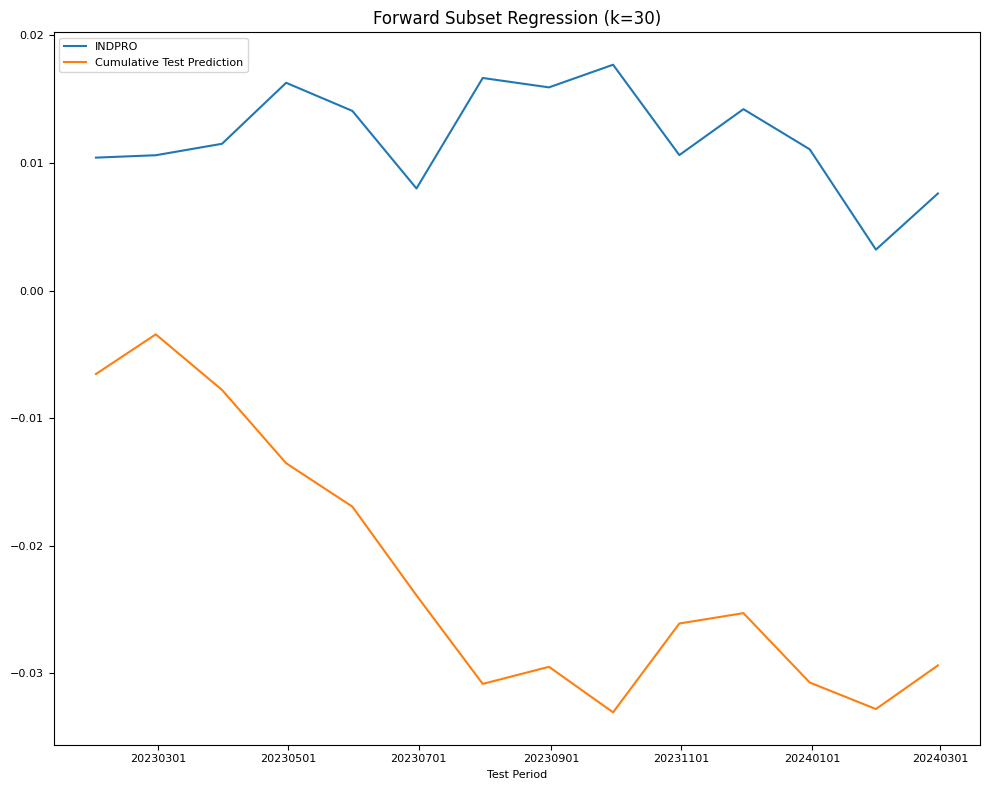

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [72]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Forward Subset Regression (k=30),0.005965,0.008271


### Partial Least Squares Regression

K-Fold cross validation


In [73]:

# split train and test, fit standard scaling using train set
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [74]:
# fit with 5-fold CV to choose n_components
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in np.arange(1, 31):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(estimator=pls,
                            X=X_train,
                            y=Y_train,
                            n_jobs=5,
                            verbose=VERBOSE,
                            cv=kf,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

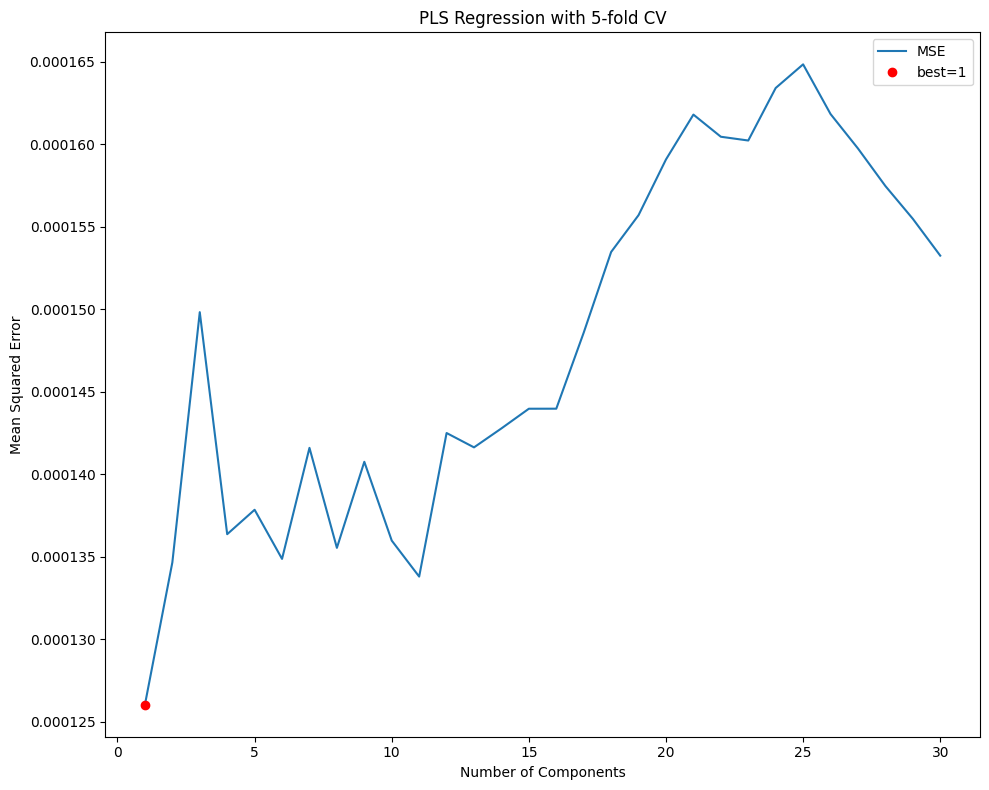

In [75]:
# show cross-validation results and best model
fig, ax = plt.subplots(figsize=(10, 8))
mse.plot(ylabel='Mean Squared Error',
         xlabel='Number of Components',
         title=f"PLS Regression with {n_splits}-fold CV",
         ax=ax)
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['MSE', f"best={best}"])
plt.tight_layout()

In [76]:
### evaluate train and test mse
model = PLSRegression(n_components=best).fit(X_train, Y_train)
name = f"PLS Regression(k={best})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))

In [77]:
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

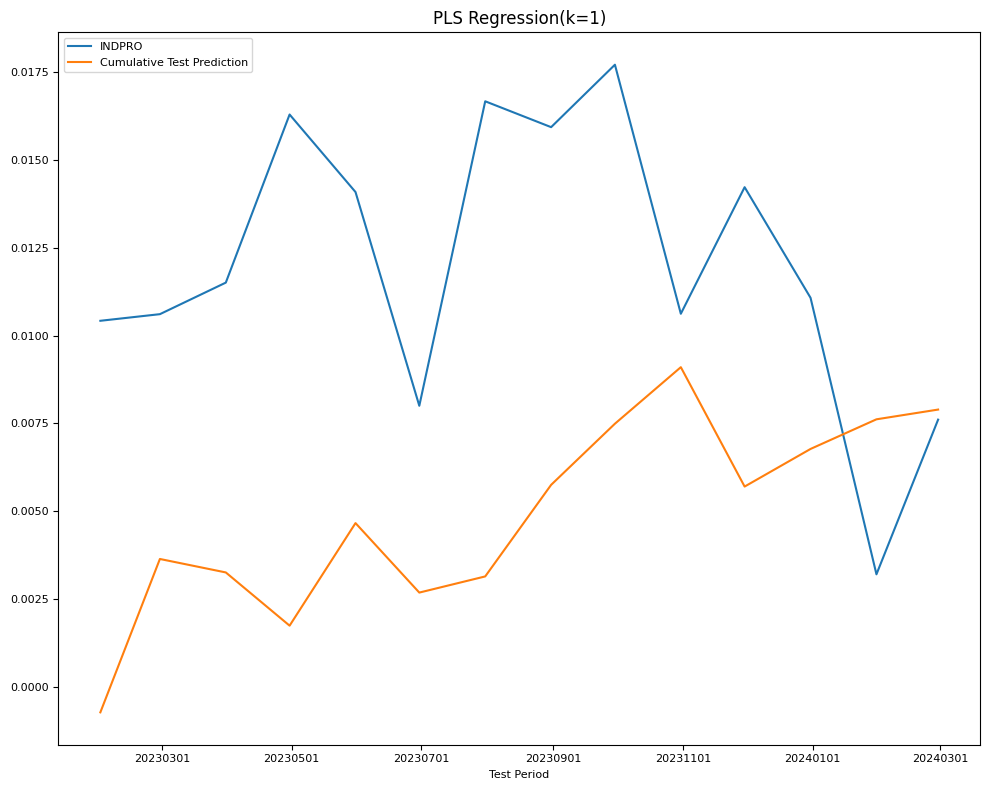

In [78]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [79]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,PLS Regression(k=1),0.00856,0.006206


### Ridge Regression

Cross validation


In [80]:
from sklearn.linear_model import Ridge, RidgeCV
alphas = 10**np.linspace(5, -4, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)
np.random.seed(42)

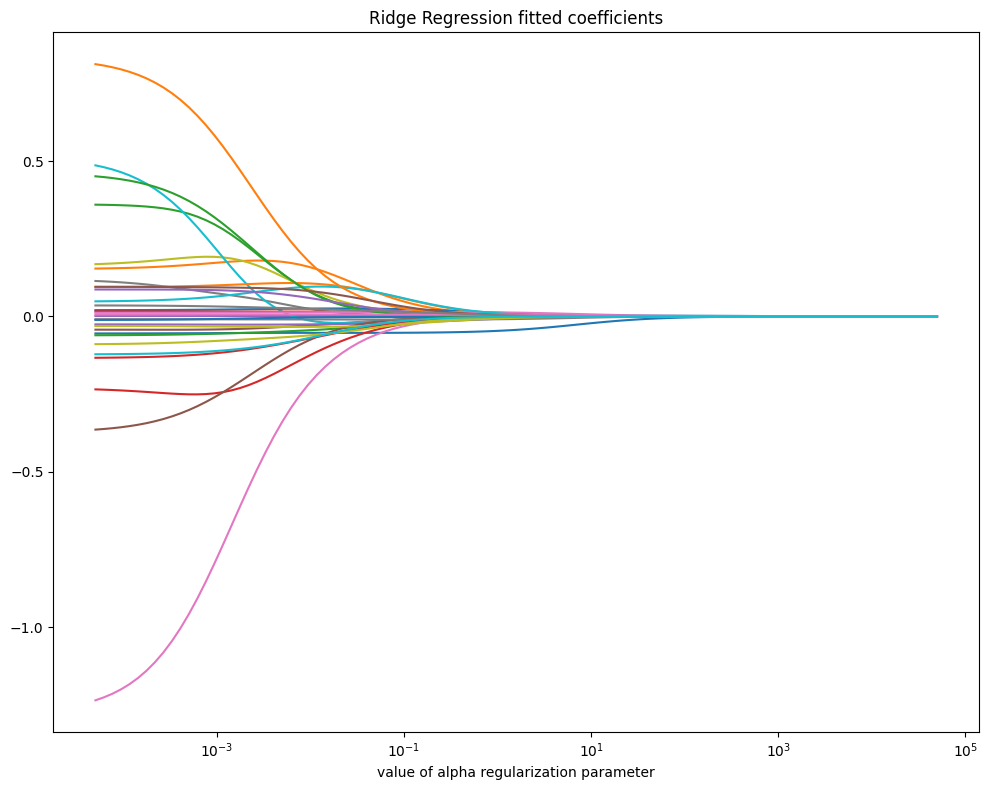

In [81]:
# Plot fitted coefficients vs regularization alpha
coefs = [Ridge(alpha, fit_intercept=False)\
         .fit(X_subset, Y_train).coef_ for alpha in alphas]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('value of alpha regularization parameter')
ax.set_title('Ridge Regression fitted coefficients')
plt.tight_layout()

In [82]:
# RidgeCV LOOCV
model = RidgeCV(alphas=alphas,
                scoring='neg_mean_squared_error',
                cv=None,  # to use Leave-One-Out cross validation
                store_cv_values=True).fit(X_train, Y_train)

In [83]:
name = f"Ridge (alpha={model.alpha_:.1f})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

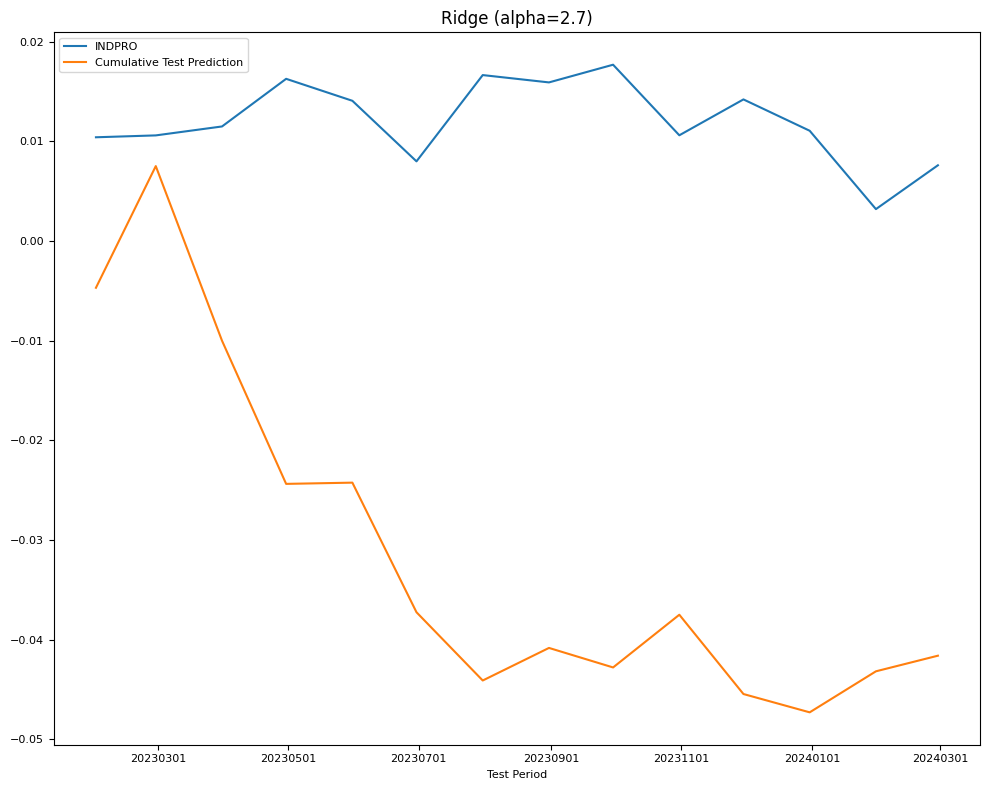

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [85]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Ridge (alpha=2.7),0.004358,0.011474


###  Lasso Regression

Cross Validation

In [86]:
from sklearn.linear_model import Lasso, LassoCV
alphas = 10**np.linspace(-2, -9, 100)*0.5  # for parameter tuning
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

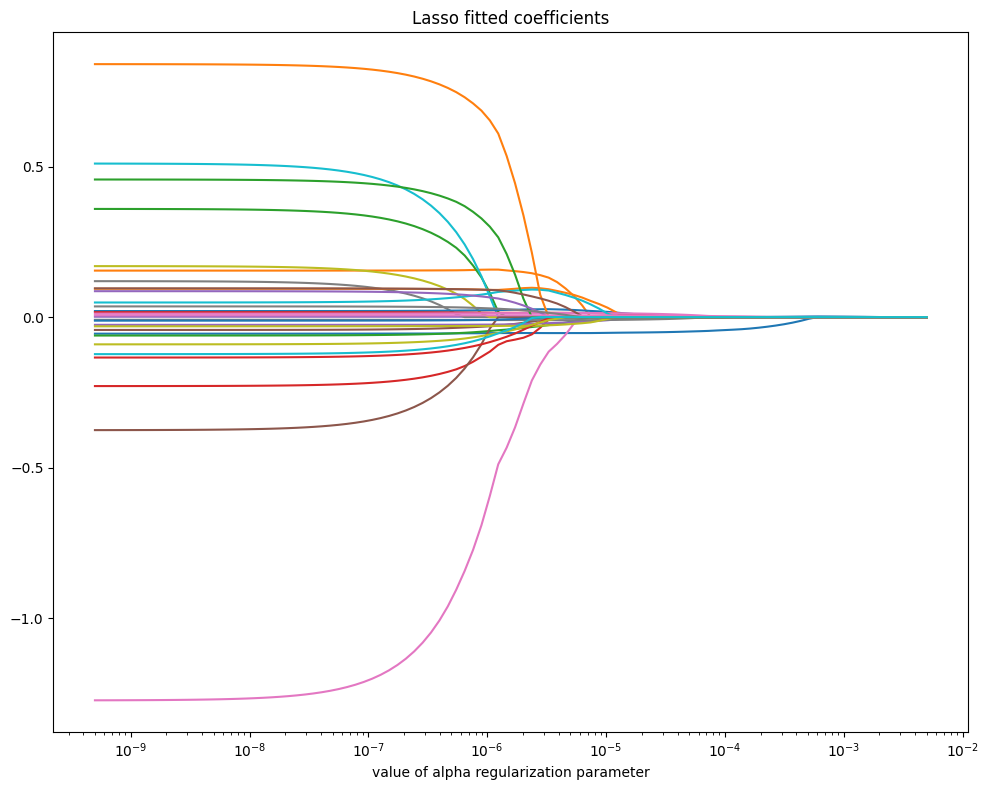

In [87]:
# Plot fitted coefficients vs regularization
coefs = [Lasso(max_iter=10000, alpha=alpha)\
         .fit(X_subset, Y_train).coef_  for alpha in alphas]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('value of alpha regularization parameter')
ax.set_title('Lasso fitted coefficients')
plt.tight_layout()

In [88]:
# LassoCV 10-Fold CV
model = LassoCV(alphas=None,
                cv=5,
                n_jobs=5,
                verbose=VERBOSE,
                max_iter=20000).fit(X_train, Y_train)
name = f"Lasso (alpha={model.alpha_:.3g})"
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

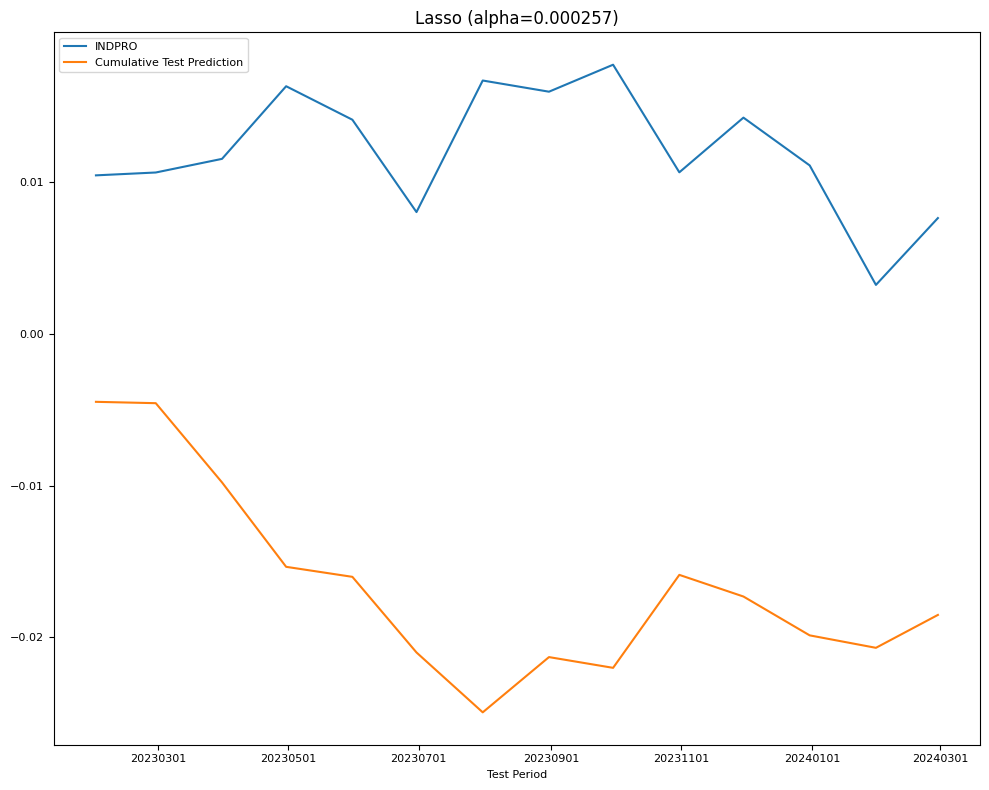

In [89]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [90]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Lasso (alpha=0.000257),0.006304,0.007601


In [91]:
# Display nonzero coefs
nonzero = np.sum(np.abs(model.coef_) > 0)
argsort = np.flip(np.argsort(np.abs(model.coef_)))[:nonzero]
df = DataFrame({'series_id': columns_unmap(X.columns[argsort])[0],
                'lags': columns_unmap(X.columns[argsort])[1],
                'desc': [alf.header(s)
                         for s in columns_unmap(X.columns[argsort])[0]],
                'coef': model.coef_[argsort]}).round(6).set_index('series_id')
print("Lasso: Nonzero Coefficients")
df

Lasso: Nonzero Coefficients


,lags,desc,coef
series_id,,,
CLAIMS,1,Initial Claims,-0.005390
SRVPRD,1,"All Employees, Service-Providing",-0.001311
M2REAL,2,Real M2 Money Stock,0.000903
IPNMAT,3,Industrial Production: Non-Durable Goods Mater...,0.000708
VIXCLS,1,CBOE Volatility Index: VIX,-0.000705
...,...,...,...
IPFUELS,3,Industrial Production: Non-Durable Consumer En...,-0.000033
IPNCONGD,1,Industrial Production: Non-Durable Consumer Goods,-0.000023
WPSFD49502,2,Producer Price Index by Commodity: Final Deman...,0.000017


### Decision Tree
The tree-based methods involve stratifying or segmenting the
predictor space into a number of simple regions. In order to make a
prediction for a given observation, we typically use the mean or the
mode of the training observations in the region to which it
belongs. The set of splitting rules used to segment the predictor
space can be summarized in a tree.



- A __Decision tree__ consistes of a series of splitting rules, that
  segments observations into regions of predictor space. Decision
  trees are typically drawn upside down, in the sense that the leaves
  are at the bottom of the tree.
- __Terminal nodes__ or __leaves__ are partitions of the predictor space
  that observations are segmented into.
- __Internal nodes__ are points along the tree where the
  predictor space is split.
- __Branches__ are those segments of the trees that connect the nodes.
- A __Stump__ is a decision tree with only one internal node.

__Recursive binary splitting__ is a top-down, greedy approach to
construct decision trees. It begins at the top of the tree (at which
point all observations belong to a single region) and then
successively splits the predictor space; each split is indicated via
two new branches further down on the tree. At each step of the
tree-building process, the best split is made at that particular step,
rather than looking ahead and picking a split that will lead to a
better tree in some future step. We first select that pre- dictor and
the cutpoint $s$ such that splitting the predictor space into the
regions leads to the greatest possible reduction in a cost function
(RSS). Next, we repeat the process, looking for the best predictor and
best cutpoint in order to split the data in one of the two previously
identified regions further so as to minimize the cost within each of
the resulting regions. The process continues until a stopping
criterion is reached.


A procedure that grows trees until the leaves are pure tends to
overfit. The complexity of the tree lies in the number of nodes. We
artificially limit the maximum size of each tree, as measured by the
number of nodes it's allowed to have, indicated on the horizontal axis
of the fitting graph. For each tree size we create a new tree from
scratch, using the training data. We measure two values: its accuracy
on the training set and its accuracy on the holdout (test) set. As the
trees are allowed to get larger, the training- set accuracy continues
to increase, but the holdout accuracy eventually declines.
The complexity at which holdout accuracy declines as the tree grows
past its ``sweet spot''.

The __cost complexity pruning__ strategy reduces the complexity
of a tree (that is less likely to overfit the data) is to grow a very
large tree, and then prune it back in order to obtain a
subtree. However, estimating the test error from cross-validation
error for every possible subtree is too cumbersome, since there is an
extremely large number of possible subtrees. Cost complexity pruning
(also known as weakest link pruning) considers a sequence of trees
indexed by a nonnegative tuning parameter $\alpha$, rather than
considering every possible subtree. For each value of $\alpha$ there
corresponds a subtree $T$ such that $\sum_{m=1}^{|T|} \sum_{x_i \in                                            
  R_m} (y_i - \hat{y}_{R_{m}})^2 + \alpha |T|$ is as small as
possible, where $|T|$ indicates the number of terminal nodes of the
tree $T$, $R_m$ is the subset of predictor space corresponding to the
$m$th terminal node, and $\hat{y}_{R_{m}}$ is the predicted response
associated with $R_m$. The tuning parameter $\alpha$ controls a
trade-off between the subtree's complexity (number of terminal nodes)
and its fit to the training data.


Alternate criteria of impurity for making the binary splits in a
classification tree:

- __Classification error rate__ (i.e. the fraction of the training
  observations in that region that do not belong to the most common
  class) is not sufficiently sensitive for tree-growing.
  $\hat{\rho}_{m,c} \dfrac{n_{m,c}}{n_m}$, where $n_m$ is the number
  of observations in node $m$, and $n_{m,c}$ is the number of
  observations in node $m$ that are in category $c$.

- __Gini index__ is a measure of total variance across the $K$
  classes, is defined by 
  $$G = \sum_{k=1}^{K} \hat{\rho}_{mk}(1-\hat{\rho}_{mk})$$
  where $\hat{\rho}_{mk}$ represent the proportion of training observations in the $m$th region that are from the $k$th class. It is not hard to see that the Gini index takes on a small value if all of the $\hat{\rho}_{mk}$'s are close to zero or one. For this reason the Gini index is referred as a measure of node purity -- a small value indicates that a node contains predominantly observations from a single class.                                                                                                       
-  __Entropy__, given by 
   $$D = \sum_{k=1}^{K}\hat{\rho}_{mk} \log \hat{\rho}_{mk}.$$ 
   The entropy will take on a value near zero if the $\hat{\rho}_{mk}$'s are all near zero or near one, when the $m$th node is pure.                                                                                                      

For classification, 

$$Deviance = -2\sum_{m=1}^{g} \sum_{1}^{w} n_{m,c}\ln \hat{p}_{m-c}$$ 

$$Residual~mean~deviance = \dfrac{\mathrm{deviance}}{n-1}$$                                                                             
                                                                                                               
If there is a highly non-linear and complex relationship between the                                           
features and the response, then decision trees (which assume a model                                           
of the form $f(x) = \sum_{m=1}^{M} c_m \cdot 1_{(X \in R_m)}$) may
outperform linear regression models (which assume the form $f(x) = \beta_0 \sum_{j=1}^{p} X_j \beta_j$)

Advantages
- Trees are very easy to explain to people. In fact, they are even
  easier to explain than linear regression!
- Decision trees may more closely mirror human decision-making
  than do the regression and classification approaches.
- Trees can be displayed graphically, and are easily interpreted
  even by a non-expert (especially if the trees are small).
- Trees can easily handle qualitative predictors without the need
  to create dummy variables

Disadvantages:
- Trees generally do not have the same level of predictive
  accuracy as some of the other regression and classification
- Trees can be very non-robust. In other words, a small change in
  the data can cause a large change in the final estimated tree.
- Trees overfits categorical variables

By aggregating many decision trees, using ensemble methods like
bagging, random forests, and boosting, the predictive performance of
trees can be substantially improved.



### Gradient boosting

KFold cross validation


In [92]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)
scale = StandardScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)

In [93]:
# tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
mse = Series(dtype=float)
for i in range(1, 10): # tune max_depth for best performance
    boosted = GradientBoostingRegressor(max_depth=i, random_state=0)
    score = cross_val_score(boosted,
                            X_train,
                            Y_train,
                            cv=kf,
                            n_jobs=5,
                            verbose=VERBOSE,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score

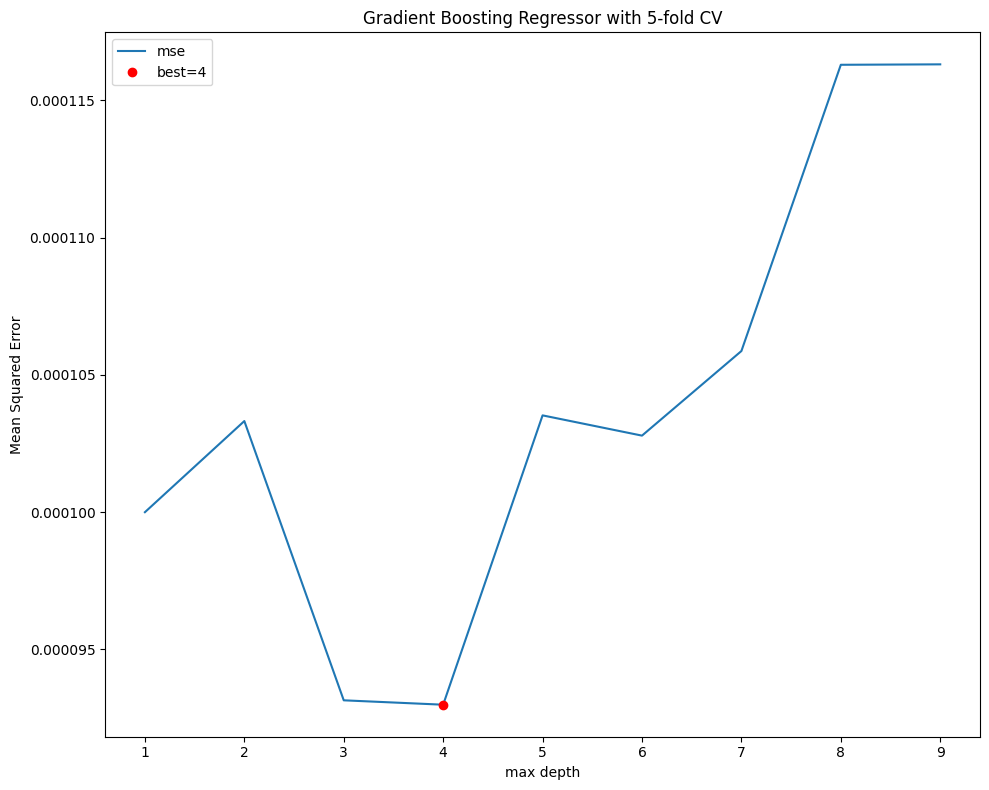

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
mse.plot(ax=ax, ylabel='Mean Squared Error', xlabel='max depth',
         title=f"Gradient Boosting Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['mse', f"best={best}"])
plt.tight_layout()

In [95]:
# evaluate train and test MSE
name = f"Boosting (depth={best})"
model = GradientBoostingRegressor(max_depth=best,
                                  random_state=0).fit(X_train, Y_train)

In [96]:
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

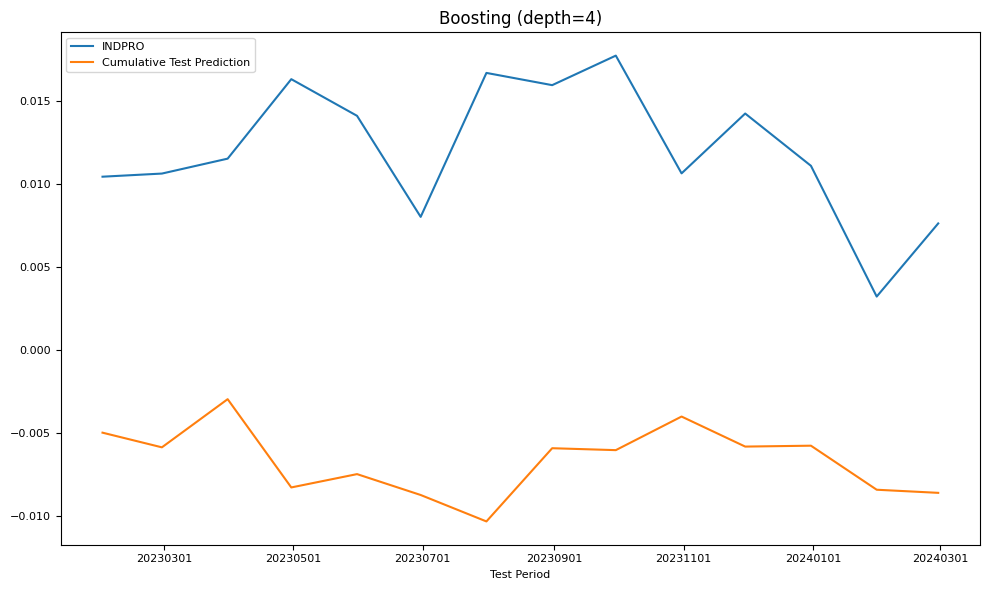

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [98]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,Boosting (depth=4),0.001661,0.00698


In [99]:
# Show feature importance
top_n = 10
imp = Series(model.feature_importances_, index=X.columns).sort_values()
print(f"Gradient Boosting: Top {top_n} Feature Importances")
DataFrame.from_dict({i+1: {'importance': imp[s],
                           'series_id': s.split('_')[0],
                           'lags': s.split('_')[1],
                           'description': alf.header(s.split('_')[0])}
                     for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                    orient='index')

Gradient Boosting: Top 10 Feature Importances


,importance,series_id,lags,description
1,0.179785,CLAIMS,1,Initial Claims
2,0.088659,M2SL,1,M2
3,0.040664,BUSLOANS,1,"Commercial and Industrial Loans, All Commercia..."
4,0.030011,HWIURATIO,1,Ratio of Help Wanted/No. Unemployed
5,0.027526,UEMPLT5,3,Number Unemployed for Less Than 5 Weeks
6,0.025408,MANEMP,1,"All Employees, Manufacturing"
7,0.018103,IPNMAT,1,Industrial Production: Non-Durable Goods Mater...
8,0.017666,PERMITW,1,New Privately-Owned Housing Units Authorized i...
9,0.016720,EXCAUS,1,Canadian Dollars to U.S. Dollar Spot Exchange ...
10,0.016259,USGOOD,1,"All Employees, Goods-Producing"


### Random Forest

KFold cross validation


In [100]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, Y_train, Y_test = ts_split(X, Y)

In [101]:
# tune max_depth with 5-fold CV
n_splits=5
kf = KFold(n_splits=n_splits,
           shuffle=True,
           random_state=0)
mse = Series(dtype=float)
for i in range(3, 20): #tune for best performance
    model = RandomForestRegressor(max_depth=i, random_state=0)
    score = cross_val_score(model,
                            X_train,
                            Y_train,
                            cv=kf,
                            n_jobs=5,
                            verbose=VERBOSE,
                            scoring='neg_mean_squared_error').mean()
    mse.loc[i] = -score
    #print(i, np.sqrt(abs(score)))

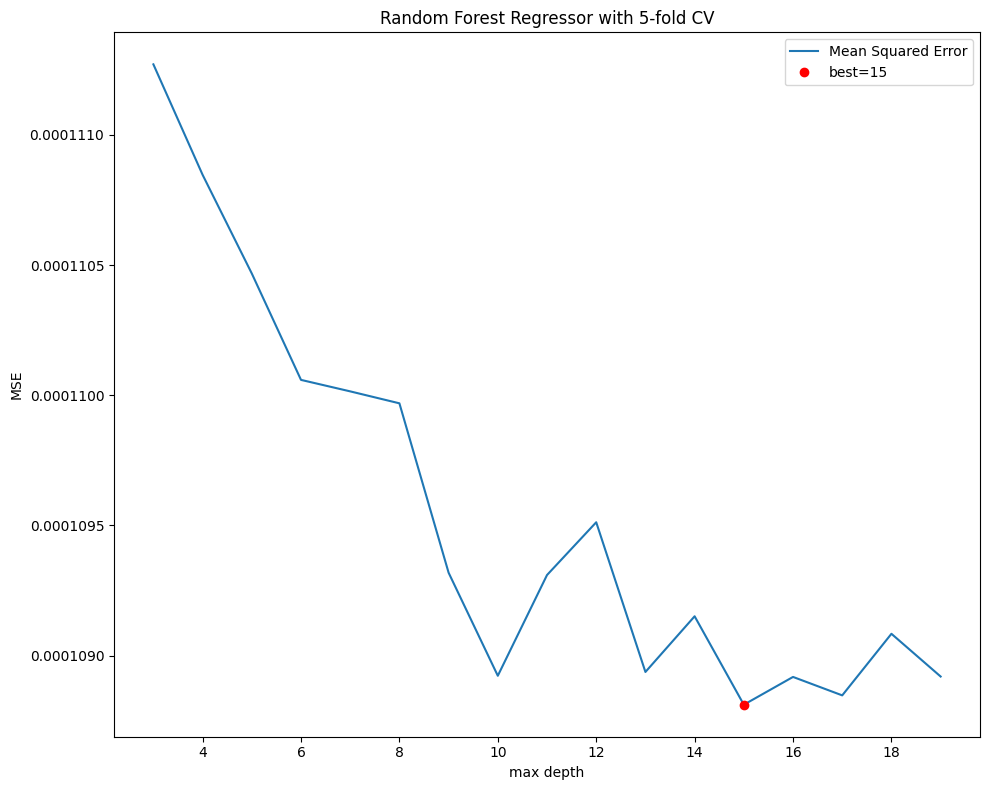

In [102]:
fig, ax = plt.subplots(figsize=(10, 8))
mse.plot(ax=ax, ylabel='MSE', xlabel='max depth',
         title=f"Random Forest Regressor with {n_splits}-fold CV")
best = mse.index[mse.argmin()]
ax.plot(best, mse.loc[best], "or")
ax.legend(['Mean Squared Error', f"best={best}"])
plt.tight_layout()

In [103]:
name = f"RandomForest (depth={best})"
model = RandomForestRegressor(max_depth=best,
                              random_state=0).fit(X_train, Y_train)

In [104]:
Y_pred = Series(index=Y_test.index,
                data=model.predict(X_test).reshape((-1,)))
test[name] = mean_squared_error(Y_test, Y_pred)
train[name] = mean_squared_error(Y_train, model.predict(X_train))
final_models[name] = model

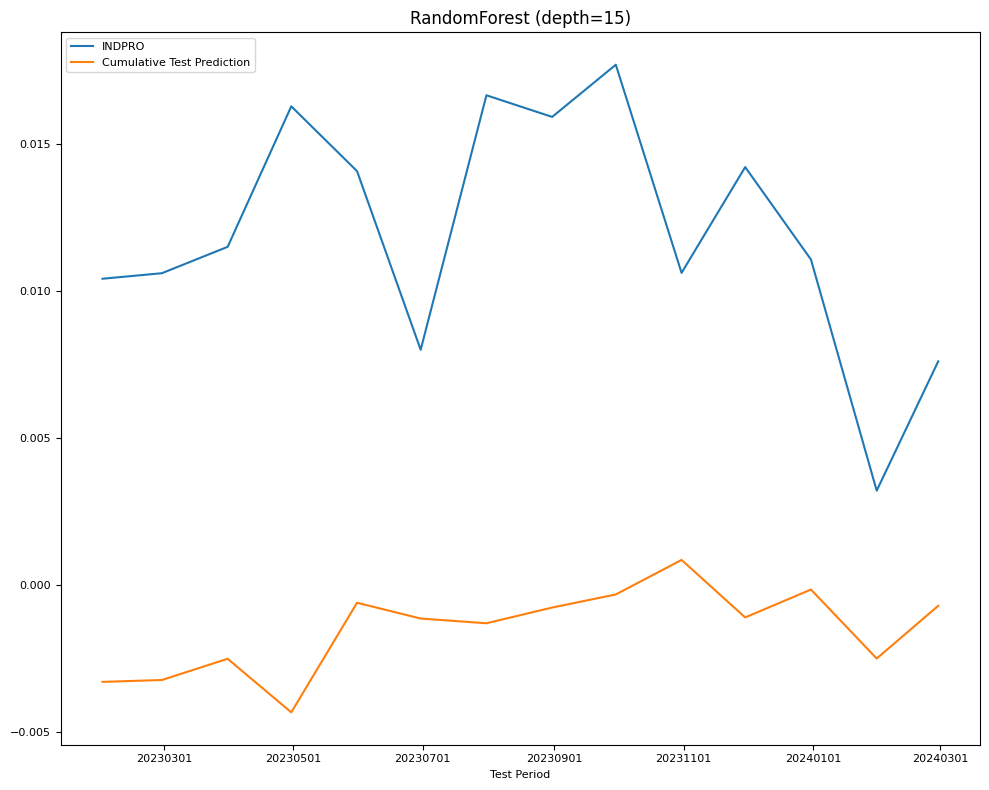

In [105]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_date(pd.concat([Y_test.cumsum(), Y_pred.cumsum()], axis=1),
          legend1=[target_id, 'Cumulative Test Prediction'],
          title=name,
          xlabel='Test Period',
          fontsize=8,
          ax=ax)
plt.tight_layout()

In [106]:
DataFrame({'name': name,
           'train': np.sqrt(train[name]),
           'test': np.sqrt(test[name])}, index=['RMSE'])

,name,train,test
RMSE,RandomForest (depth=15),0.003833,0.006165


In [107]:
# Feature importance
top_n = 10
imp = Series(model.feature_importances_, index=X.columns).sort_values()
print(f"Random Forest: Top {top_n} Feature Importances")
DataFrame.from_dict({i+1: {'importance': imp[s],
                          'series_id': s.split('_')[0],
                          'lags': s.split('_')[1],
                          'description': alf.header(s.split('_')[0])}
                    for i, s in enumerate(np.flip(imp.index[-top_n:]))},
                   orient='index')

Random Forest: Top 10 Feature Importances


,importance,series_id,lags,description
1,0.051142,CLAIMS,1,Initial Claims
2,0.047626,BUSLOANS,1,"Commercial and Industrial Loans, All Commercia..."
3,0.044440,M2SL,1,M2
4,0.027707,USGOOD,1,"All Employees, Goods-Producing"
5,0.016242,UEMPLT5,1,Number Unemployed for Less Than 5 Weeks
6,0.014992,UEMPLT5,3,Number Unemployed for Less Than 5 Weeks
7,0.014374,IPCONGD,1,Industrial Production: Consumer Goods
8,0.014345,M1SL,1,M1
9,0.012969,OILPRICE,1,"Crude Oil, spliced WTI and Cushing"
10,0.012449,MANEMP,1,"All Employees, Manufacturing"


## Evaluation

RMSE


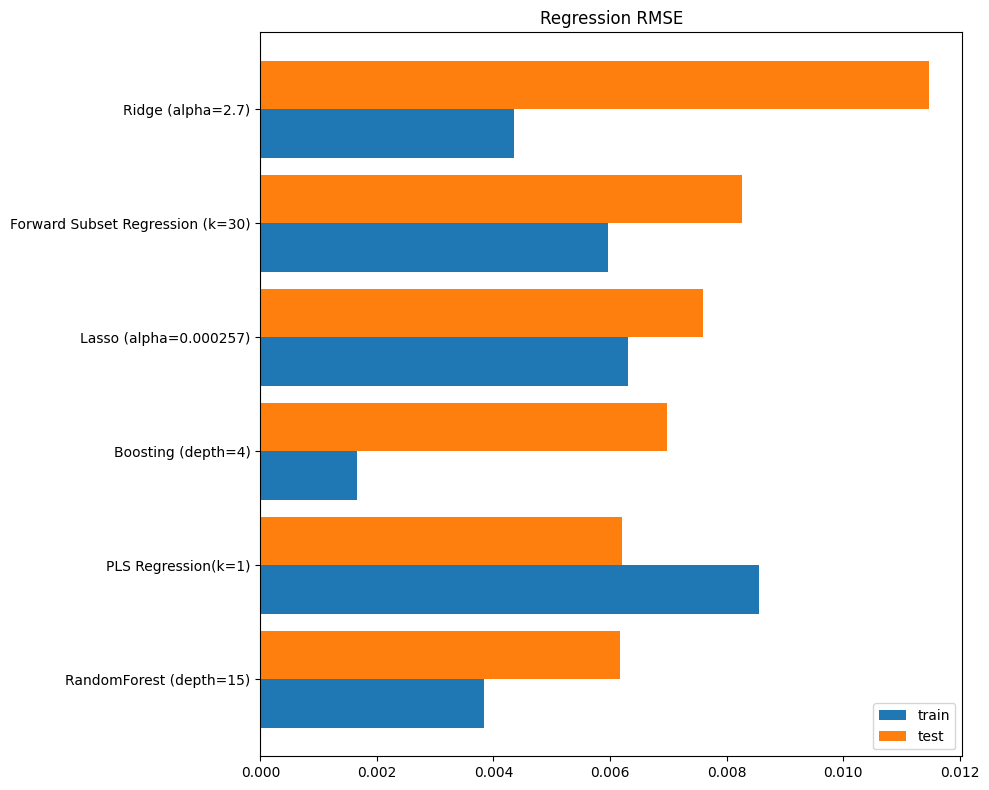

In [108]:
fig, ax = plt.subplots(figsize=(10, 8))
pd.concat([np.sqrt(r.to_frame()) for r in [train, test]], axis=1)\
  .sort_values('test')\
  .plot.barh(ax=ax, width=0.85)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_title('Regression RMSE')
ax.figure.subplots_adjust(left=0.35)
plt.tight_layout()